# Quantum Kernels and Support Vector Machines

## Credit card fraud detection - simple use case

#### QSVM on Kaggle labeled data as means to classify and detect credit card fraudulant transactions


- Quantum Machine Learning (QML) is the aspect of research that explores the consequences of implementing machine learning on a quantum computer
- SVM is a supervised machine learning method widely used for multiple labeled data classification.
- SVM algorithm can be enhanced even on a noisy intermediate scale quantum computer (NISQ) by introducing kernel method.

  It can be restructured so that it can exploit the properties of large dimensionality of quantum Hilbert space
- In this demo we will present a simple use case where Quantum SVM (QSVM) algorithm will be implemented on credit card labeled data to detect fraudulent transactions
- We will leverage Classiqs proprietary QSVM library and core capabilities to explore the rising potential in enhancing security applications



#### Demostration is based on recent work published on August 2022 [[1](#HBC)]

*In this demo, besides the `classiq` package, we will use the `sklearn` package*

In [1]:
%%capture
! pip install scikit-learn
! pip install seaborn

*Importing the required resources:*

In [2]:
# General Imports
# Visualisation Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Scikit Imports
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [3]:
## For TSNE visualisation
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import scale

# Random state.
RS = 20150101

import matplotlib
import matplotlib.colors as colors

# We'll use matplotlib for graphics.
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt

# We import seaborn to make nice plots.
try:
    import seaborn as sns
except ModuleNotFoundError:
    palette = np.array(
        [
            (0.4, 0.7607843137254902, 0.6470588235294118),
            (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
            (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
            (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
            (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
            (1.0, 0.8509803921568627, 0.1843137254901961),
            (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
            (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
        ]
    )
else:
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = np.array(sns.color_palette("Set2"))

import warnings

warnings.filterwarnings("ignore")

In [4]:
## Classiq imports

from classiq import Pauli, construct_qsvm_model, execute, show, synthesize
from classiq.applications.qsvm import QSVMFeatureMapEntanglement

## The Data

The dataset contains **transactions made by credit cards in September 2013 by European cardholders**.

This dataset presents transactions that occurred in **two days**, where there were **492 frauds** out of **284,807 transactions**.
The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Data properties:
- Database contains only numeric input variables which are the result of a PCA transformation.
- Due to confidentiality issues, original features are not provided.
- Features V1, V2, … V28 are the principal components obtained with PCA.
- The only features which have not been transformed with PCA are 'Time' and 'Amount'.
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
- The feature 'Amount' is the transaction Amount.
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


##### Data is freely available through Kaggle [[2](#Kaggle)]

### Loading the Kaggle "Credit Card Fraud Detection" data set

In [5]:
import pathlib

path = (
    pathlib.Path(__file__).parent.resolve()
    if "__file__" in locals()
    else pathlib.Path(".")
)
input_file = path / "../resources/creditcard.csv"
# comma delimited file as input
kaggle_full_set = pd.read_csv(input_file, header=0)
# presnting first 5 lines:
kaggle_full_set.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<div class="alert alert-block alert-success">

## 1. Data Preprocessing

</div>

### Selecting training and testing data sets

To proceed with the analysis, we sub-sample the dataset to make it manageable for near-term quantum simulations

In [6]:
TRAIN_NOMINAL_SIZE = 100
TRAIN_FRAUD_SIZE = 25

TEST_NOMINAL_SIZE = 50
TEST_FRAUD_SIZE = 10

PREDICTION_NOMINAL_SIZE = 50
PREDICTION_FRAUD_SIZE = 10

SHUFFLE_DATA = False

In [7]:
## Seperating nominal ("legit") from fraud:
all_fraud_set = kaggle_full_set.loc[kaggle_full_set["Class"] == 1]
all_nominal_set = kaggle_full_set.loc[kaggle_full_set["Class"] == 0]

In [8]:
## Optionally shuffle data before selctive sets
if SHUFFLE_DATA:
    all_fraud_set = shuffle(all_fraud_set, random_state=1234)
    all_nominal_set = shuffle(all_nominal_set, random_state=1234)

In [9]:
## Selecting data subsets
selected_training_set = pd.concat(
    [all_nominal_set[:TRAIN_NOMINAL_SIZE], all_fraud_set[:TRAIN_FRAUD_SIZE]]
)
selected_testing_set = pd.concat(
    [
        all_nominal_set[TRAIN_NOMINAL_SIZE : TRAIN_NOMINAL_SIZE + TEST_NOMINAL_SIZE],
        all_fraud_set[TRAIN_FRAUD_SIZE : TRAIN_FRAUD_SIZE + TEST_FRAUD_SIZE],
    ]
)
selected_prediction_set = pd.concat(
    [
        all_nominal_set[
            TRAIN_NOMINAL_SIZE
            + TEST_NOMINAL_SIZE : TRAIN_NOMINAL_SIZE
            + TEST_NOMINAL_SIZE
            + PREDICTION_NOMINAL_SIZE
        ],
        all_fraud_set[
            TRAIN_FRAUD_SIZE
            + TEST_FRAUD_SIZE : TRAIN_FRAUD_SIZE
            + TEST_FRAUD_SIZE
            + PREDICTION_FRAUD_SIZE
        ],
    ]
)

In [10]:
## Seperating relevant features data (excluding the "Time" colom) from label data

kaggle_headers = list(kaggle_full_set.columns.values)  # all headers
feature_cols = kaggle_headers[1:-1]  # excluding Time and Class headers
label_col = kaggle_headers[-1]  # marking Class header as label

selected_training_data = selected_training_set.loc[:, feature_cols]
selected_training_labels = selected_training_set.loc[:, label_col]

selected_testing_data = selected_testing_set.loc[:, feature_cols]
selected_testing_labels = selected_testing_set.loc[:, label_col]

selected_prediction_data = selected_prediction_set.loc[:, feature_cols]
selected_prediction_true_labels = selected_prediction_set.loc[:, label_col]

### Visualization of the selected data sets with t-SNE

t-SNE is a technique for dimensionality reduction that is particularly suited for the visualization of high-dimensional datasets

In [11]:
def scatter(x, colors):
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect="equal")
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int32)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis("off")
    ax.axis("tight")

    # We add the labels for each digit.
    txts = []
    labels = ["Nominal", "Fraud"]
    for i in range(2):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, labels[i], fontsize=24)
        txt.set_path_effects(
            [PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()]
        )
        txts.append(txt)

    return

#### TSNE Visualization of train data

We observe that visually t-SNE shows a separation between nominal and anomalous samples.

However, **sole visualization map does not allow to track all fraudulent transactions.**

**This demonstrates the challenge of high-quality fraud detection.**

For the sake of quick demonstration we subselcetd a very small percentage of the data. Better logic for sub selecting the training and testing datasets will effect quality of results.

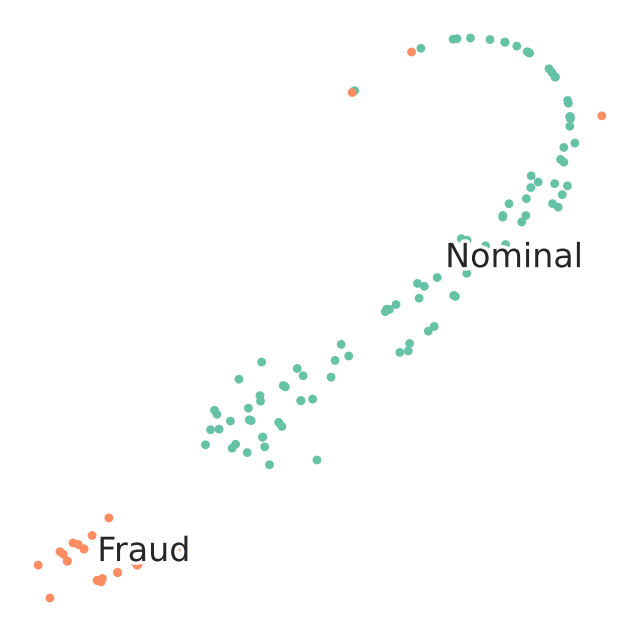

In [12]:
proj = TSNE(random_state=RS).fit_transform(selected_training_data)
scatter(proj, selected_training_labels)

#### TSNE Visualization of test data

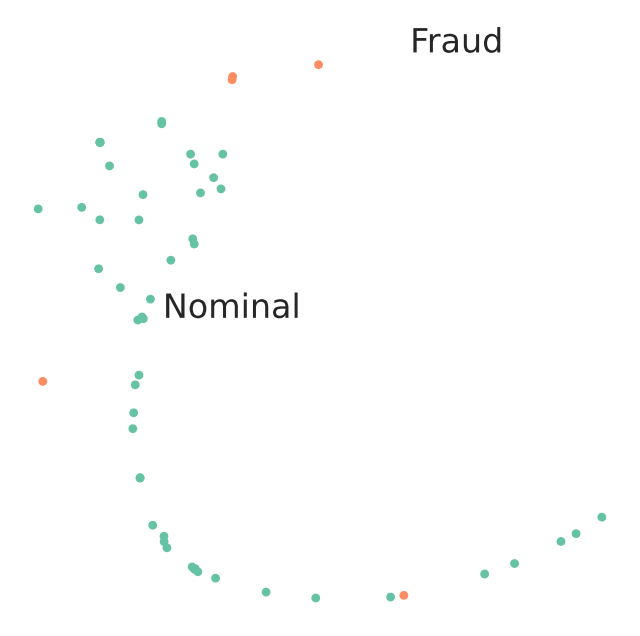

In [13]:
proj = TSNE(random_state=RS).fit_transform(selected_testing_data)
scatter(proj, selected_testing_labels)

### Reduce dimensions

**Convert original features into fewer features to match the number of Qubits**

We perform dimensionality reduction to match
the number of features with the number of qubits used in
simulation.  For this, we use principal component analysis
and keep only the first *N_DIM* principal components.


In [14]:
## choosing data dimension to encode
N_DIM = 3

In [15]:
sample_train = selected_training_data.values.tolist()
sample_test = selected_testing_data.values.tolist()
sample_predict = selected_prediction_data.values.tolist()

# Reduce dimensions

pca = PCA(n_components=N_DIM).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)
sample_predict = pca.transform(sample_predict)

### Normalize

We use feature-wise standard scaling, i.e.
we subtract the mean and scale by the standard deviation for each feature

In [16]:
# Normalize
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)
sample_predict = std_scale.transform(sample_predict)

### Scale

Scaling each feature to a range between -$\pi$ and $\pi$.

In [17]:
# Scale
samples = np.append(sample_train, sample_test, axis=0)
samples = np.append(samples, sample_predict, axis=0)
minmax_scale = MinMaxScaler((-np.pi, np.pi)).fit(samples)
FRAUD_TRAIN_DATA = minmax_scale.transform(sample_train)
FRAUD_TEST_DATA = minmax_scale.transform(sample_test)
FRAUD_PREDICT_DATA = minmax_scale.transform(sample_predict)

### Final preprocessed data set

In [18]:
FRAUD_TRAIN_LABELS = np.array(selected_training_labels.values.tolist())
FRAUD_TEST_LABELS = np.array(selected_testing_labels.values.tolist())

<div class="alert alert-block alert-success">

## 2. Map data to Hilbert Space

</div>

### FeatureMap design with Classiq

The feature map is a parameterized quantum circuit, which can be described as a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$ on n qubits.

Since the data may be non-linearly-separable in the original space, **the feature map circuit will map the classical data into Hilbert space**.

The choice of which feature map circuit to use is key and may depend on the given dataset we want to classify.
We will leverage Classiq feature map design capabilities

#### Choose existing feature map type (or build our own)
As an example we can choose from the well known the Second-order Pauli-Z evolution encoding circuit with 2 repetitions OR the bloch sphere circuit encoding

In [19]:
## Choosing "Pauli ZZ" feature map encodign with 2 repetitions:
pauli_zz_feature_map_function_name = "pauli_feature_map"
pauli_zz_kwargs = {
    "paulis": [[Pauli.Z], [Pauli.Z, Pauli.Z]],
    "entanglement": QSVMFeatureMapEntanglement.FULL,
    "alpha": 2,
    "reps": 2,
    "feature_dimension": N_DIM,
}

## Choosing "bloch sphere" feature map encoding:
bloch_sphere_feature_map_function_name = "bloch_sphere_feature_map"
bloch_sphere_kwargs = {"bloch_feature_dimension": N_DIM}

<div class="alert alert-block alert-success">

## 3. Execute QSVM

</div>




Quantum Support Vector Machines is the **Quantum version of SVM - a data classification method which separates the data using a hyperplane**.

The algorithm will perform the following steps [[3](#3)]:

1. **Estimating the kernel matrix**

    - A quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, which can be seen as a measure of similarity: $k(\mathbf{x}_i,\mathbf{x}_j)$ is large when $\mathbf{x}_i$ and $\mathbf{x}_j$ are close.

    - When considering finite data, we can represent the quantum kernel as a matrix:
    $K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$.

        **We can calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude**:
        $$
        \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} =
        \left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
        $$

        This provides us with an estimate of the quantum kernel matrix, which will be used in the support vector classification.


2. **Optimizing** the dual problem by **using the classical SVM algorithm to generate a separating Hyperplane and classify the data**
$$ L_D(\alpha) = \sum_{i=1}^t \alpha_i - \frac{1}{2} \sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\vec{x}_i \vec{x}_j) $$
    - Where $t$ is the amount of data points
    - the $\vec{x}_i$s are the data points
    - $y_i$ is the label $\in \{-1,1\}$ of each data point
    - $K(\vec{x}_i \vec{x}_j)$ is the kernel matrix element between the $i$ and $j$ datapoints
    - We optimize over the $\alpha$s
    - We expect most of the $\alpha$s to be $0$. The $\vec{x}_i$s that correspond to non-zero $\alpha_i$ are called the Support Vectors.

### Setup Classiq QSVM model:

In [20]:
## Setting QSVM model with feature map and data

QSVM_FRAUD_PAULI_ZZ = construct_qsvm_model(
    train_data=FRAUD_TRAIN_DATA.tolist(),
    train_labels=FRAUD_TRAIN_LABELS.tolist(),
    test_data=FRAUD_TEST_DATA.tolist(),
    test_labels=FRAUD_TEST_LABELS.tolist(),
    predict_data=FRAUD_PREDICT_DATA.tolist(),
    feature_map_function_name=pauli_zz_feature_map_function_name,
    **pauli_zz_kwargs
)

QSVM_FRAUD_BLOCH_SHPERE = construct_qsvm_model(
    train_data=FRAUD_TRAIN_DATA.tolist(),
    train_labels=FRAUD_TRAIN_LABELS.tolist(),
    test_data=FRAUD_TEST_DATA.tolist(),
    test_labels=FRAUD_TEST_LABELS.tolist(),
    predict_data=FRAUD_PREDICT_DATA.tolist(),
    feature_map_function_name=bloch_sphere_feature_map_function_name,
    **bloch_sphere_kwargs
)

### Synthesize our model and explore the generated quantum circuit
Once we constructed our qsvm model - we synthesize and view the quantum circuit that encodes our data.
For this we will use `classiq` built-in `synthesize` and `show` functions:

In [21]:
from classiq import write_qmod

write_qmod(QSVM_FRAUD_PAULI_ZZ, "credit_card_fraud")

In [22]:
qprog = synthesize(QSVM_FRAUD_PAULI_ZZ)
show(qprog)

Opening: https://platform.classiq.io/circuit/ebc7a9f3-3982-4024-a151-7fd9cc64da86?version=0.45.0.dev0%2Bcf1b9b7ccc


### Run QSVM and analyze results



### Train and test the data

1. Build the train and test quantum kernel matrices.
    1. **For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability**}: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. **For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_i}$, apply the feature map and measure the transition probability**: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and **test quantum kernel matrices in a classical support vector machine classification algorithm**.


Executing QSVM is done though the `execute` function.
The execution results will include the accuracy of the classification and the predicted labels for the predict data.


In [23]:
results = execute(qprog).result()

In [24]:
print(
    "quantum kernel classification test score:  %0.2f"
    % (results[0].value["test_score"])
)

quantum kernel classification test score:  0.92


**Result seems quite good. It's a good start! Let's analyze it further:**

#### Compare testing accuracy results to classical kernels:

In [25]:
classical_kernels = ["linear", "poly", "rbf", "sigmoid"]

for ckernel in classical_kernels:
    classical_svc = SVC(kernel=ckernel)
    classical_svc.fit(FRAUD_TRAIN_DATA, FRAUD_TRAIN_LABELS)
    classical_score = classical_svc.score(
        FRAUD_TEST_DATA, np.array(FRAUD_TEST_LABELS.tolist())
    )

    print("%s kernel classification test score:  %0.2f" % (ckernel, classical_score))

linear kernel classification test score:  1.00
poly kernel classification test score:  1.00
rbf kernel classification test score:  1.00
sigmoid kernel classification test score:  0.98


Given our simple naive training and testing set example, the **Quantum kernel gets results "at least as good as" the classical kernels** -  can be interpetted as **prominsing sign** and encourage deeper research. Baring in mind the following:
- Quantum kernel machine algorithms only have the potential of quantum advantage over classical approaches if the corresponding quantum kernel is hard to estimate classically (a necessary and not always sufficient condition to obtain a quantum advantage)

- However, it was proven recently [[4](#4)] that learning problems exist for which learners with access to quantum kernel methods have a quantum advantage over all classical learners.

### Predict data


  Finally, we may predict unlabeled data by calculating the kernel matrix of the new datum with respect to the support vectors
    $$ \text{Predicted Label}(\vec{s}) = \text{sign} \left( \sum_{i=1}^t y_i \alpha_i^* K(\vec{x}_i , \vec{s}) + b \right) $$
        - Where $\vec{s}$ is the datapoint to be classified
        - $\alpha_i^*$ are the optimized $\alpha$s
        - And $b$ is the bias.

In [26]:
true_labels = np.array(selected_prediction_true_labels.values.tolist())
sklearn.metrics.accuracy_score(results[0].value["predicted_labels"], true_labels)

0.9333333333333333

<div class="alert alert-block alert-success">


## Quantum advantage is possible:

**QSVM has the *potential* for enhancing performance, accuracy and even efficiency** in resources:

- **There are limitations to the successful classical solutions when the feature space becomes large**, and the kernel functions become computationally expensive to estimate

- For **certain types of data** a classifier that **exploits the quantum feature space shows better results**.





**A necessary condition to obtain a quantum advantage is that the kernel cannot be estimated classically.** Since quantum computers are not expected to be classically simulable there is a very large design space to explore.




In the future it becomes intriguing to find suitable feature maps for this technique with provable quantum advantages while providing significant improvement on real world data sets. With the ubiquity of kernel methods in machine learning, we are optimistic that our techniques will produce applications even beyond binary classification.


</div>



## References


<a id='1'>[1]</a>: [Oleksandr Kyriienko, Einar B. Magnusson "Unsupervised quantum machine learning for fraud detection"](https://arxiv.org/abs/2208.01203)

<a id='Kaggle'>[2]</a>: [Kaggle dataset - Credit Card Fraud Detection
Anonymized credit card transactions labeled as fraudulent or genuine](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

<a id='3'>[3]</a>: [Havl&#237;&#269;ek, V., C&#243;rcoles, A.D., Temme, K. et al. Supervised learning with quantum-enhanced feature spaces. Nature 567, 209-212 (2019)](https://doi.org/10.1038/s41586-019-0980-2)

<a id='4'>[4]</a>: [Liu et al. A rigorous and robust quantum speed-up in supervised machine learning (2020)](https://arxiv.org/pdf/2010.02174.pdf)
